# Tutorial: Mix of melanoma cell lines

Here we will illustrate how you can run the SCENIC+ workflow on samples with seperate scRNA-seq and scATAC-seq from different cells but the same sample.
The key thing to be able to do this is that the scATAC-seq cells are annotated to cell types/states and that these labels are shared with the scRNA-seq annotation.
Based on these annotations we can the generate pseudo-multiome data by sampling and combining a number of cells, per cell type, across both data modalities.

Here, we will use data on a mix of melanoma cell lines (MM lines; each cell line comes from a different patient) as a casestudy. This is one example where the annotation
of the cells is quite easy. The reason is that each cell line form a distinct homogeneous state, thus we can simply annotate the cells by matching them to their donor.
This matching can be done based on patient specific SNPs, to do this we have already run the tool [demuxlet](https://www.nature.com/articles/nbt.4042) on both the
scRNA-seq data and scATAC-seq data.

In your case it might be a bit more complex to annotate the scATAC-seq data, due to the lack of clear markers. However the use of *gene activity imputation* from
the scATAC-seq data followed by label transfer(see [the pycisTopic read the docs](https://pycistopic.readthedocs.io) for more information), 
simple integration of scRNA-seq and scATAC-seq data (see for example [this tutorial](https://satijalab.org/seurat/articles/atacseq_integration_vignette.html)) 
or more complex label transfer methods (for example [the bridge integration technique from Satija lab](https://satijalab.org/seurat/articles/bridge_integration_vignette.html))
might help with this taks.

<div class="alert alert-info">

**Note:**

The preprocessing steps (i.e. scRNA-seq/scATAC-seq QC, topic modeling, motif enrichment analys, ...) are very similar to the steps needed to process multiome data.
In this tutorial we will mainly focus on what is different and point out where extra care should be given. 
For a more detailed tutorial we refer to the tutorial on 3k multiome PBMC cells.
</div>

## Setting up work environment

In [3]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
work_dir = 'mm_lines'
tmp_dir = '/scratch/leuven/330/vsc33053/'

if not os.path.exists(work_dir):
    os.makedirs(work_dir)

In [6]:
!tree mm_lines | sed 's/->.*//'

mm_lines
`-- data
    |-- four_lines_demuxlet.best 
    |-- four_lines_fragments.tsv.gz 
    |-- mm_line_anndata.h5ad
    |-- seven_lines_demuxlet.best 
    `-- seven_lines_fragments.tsv.gz 

1 directory, 5 files


Above you see the data that we will be working with in this example.

The scRNA-seq data is already processed off screen given that the workflow for this is exactly the same for preprocessing scRNA-seq data from multiome data (see the tutorial on 3k multiome PBMC cells for more details). The result of this is saved in `mm_line_anndata.h5ad`.

For the scATAC-seq data we have two samples, one containing a mix of four MM lines and the other containing a mix of seven MM lines, the fragments files of these samples are named resp. `four_lines_fragments.tsv.gz` and `seven_lines_fragments.tsv.gz`.

Offscreen we have also already run demuxlet on the scATAC-seq samples (as well as on the scRNA-seq samples in fact), running demuxlet is beyond the scope of this tutorial so we provide the output for both samples in `four_lines_demuxlet.best` and `seven_lines_demuxlet.best`. We will use these demuxlet results as the main cell type annotation.

## scATAC-seq preprocessing using pycisTopic

The scATAC-seq preprocessing steps are *almost* identical to preprocessing multiome data. 
The big difference is that in this case we will not use the cell type annotation from the scRNA-seq side.
We will use the demuxlet results instead.

In [7]:
if not os.path.exists(os.path.join(work_dir, 'scATAC')):
    os.makedirs(os.path.join(work_dir, 'scATAC'))

Let's define some variables.
Because we have two samples we add two paths to the fragments files (one for each sample) to the `fragments_dict` dictionary.

In [8]:
#path to fragments files
fragments_dict = {
    'MMlines_7': os.path.join(work_dir, 'data/seven_lines_fragments.tsv.gz'),
    'MMlines_4': os.path.join(work_dir, 'data/four_lines_fragments.tsv.gz')}
#path to demuxlet results
demuxlet_dict = {
    'MMlines_7': os.path.join(work_dir, 'data/seven_lines_demuxlet.best'),
    'MMlines_4': os.path.join(work_dir, 'data/four_lines_demuxlet.best')}
#path to blacklist regions
path_to_blacklist= '../../pycisTopic/blacklist/hg38-blacklist.v2.bed'

### Generate pseudobulk ATAC-seq profiles, call peaks and generate a consensus peak set

Let's read the demuxlet results into a pandas dataframe, we will use these as the cell type annotation for generating pseudobulk ATAC-seq profiles.

In [9]:
import pandas as pd
import numpy as np

cell_data = []
for sample_id in demuxlet_dict.keys():
    dmxl = pd.read_csv(demuxlet_dict[str(sample_id)], sep="\t")
    dmxl['SNG.BEST.GUESS'] = dmxl['SNG.BEST.GUESS'].str.replace('_BL.sorted.dedup.q30.bam', '', regex=False)
    dmxl.loc[dmxl['DROPLET.TYPE'] == 'DBL', 'SNG.BEST.GUESS'] = 'DBL'
    dmxl.loc[dmxl['DROPLET.TYPE'] == 'AMB', 'SNG.BEST.GUESS'] = 'DBL'
    dmxl.rename(columns={'SNG.BEST.GUESS': 'MMline',
                        'BARCODE': 'barcode'}, inplace=True)
    dmxl = dmxl[['barcode','MMline','NUM.SNPS', 'NUM.READS']]
    dmxl['sample_id']=sample_id
    cell_data.append(dmxl)
cell_data = pd.concat(cell_data, axis = 0)

#some samples might be misscalls, we will remove these (they will have only very few cells annotated to them)
lines, cnt = np.unique(cell_data['MMline'], return_counts = True)
lines_to_remove = [l for l, count in zip(lines, cnt) if count < 5]
cell_data = cell_data.drop([cell_data.index[i] for i, l in enumerate(cell_data['MMline']) if l in lines_to_remove]).reset_index(drop = True)

#remove doublets
cell_data = cell_data.drop([cell_data.index[i] for i, l in enumerate(cell_data['MMline']) if l == 'DBL']).reset_index(drop = True)

cell_data.head()

,barcode,MMline,NUM.SNPS,NUM.READS,sample_id
0,AAACGAAAGAGAGGTA-1,MM001,2232,2232,MMlines_7
1,AAACGAAAGCGTATCT-1,MM099,2842,2842,MMlines_7
2,AAACGAAGTGCAAGCA-1,MM099,2474,2474,MMlines_7
3,AAACGAAGTGCAGACA-1,MM099,2908,2908,MMlines_7
4,AAACGAATCGATAGGG-1,MM099,1906,1906,MMlines_7


In [10]:
#save result
cell_data.to_csv(os.path.join(work_dir, 'scATAC/cell_data.tsv'), sep = '\t', header = True, index = False)

Now we can continue generating the pseudobulk ATAC-seq profiles per cell line (MMline). The workflow is now identical to the multiome workflow.

In [11]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
import pandas as pd
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [18]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
import ray
ray.shutdown()
sys.stderr = open(os.devnull, "w")  # silence stderr
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'MMline',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 bigwig_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 n_cpu = 8,                                                                                 # specify the number of cores to use, we use ray for multi processing
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
                 split_pattern = '-')
sys.stderr = sys.__stderr__  # unsilence stderr

2022-08-10 10:45:18,429 cisTopic     INFO     Reading fragments from mm_lines/data/seven_lines_fragments.tsv.gz
2022-08-10 10:46:05,484 cisTopic     INFO     Reading fragments from mm_lines/data/four_lines_fragments.tsv.gz


2022-08-10 10:47:23,799	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(export_pseudobulk_ray pid=29314) 2022-08-10 10:47:30,894 cisTopic     INFO     Creating pseudobulk for MM001
(export_pseudobulk_ray pid=29318) 2022-08-10 10:47:31,623 cisTopic     INFO     Creating pseudobulk for MM011
(export_pseudobulk_ray pid=29316) 2022-08-10 10:47:32,633 cisTopic     INFO     Creating pseudobulk for MM029
(export_pseudobulk_ray pid=29317) 2022-08-10 10:47:33,233 cisTopic     INFO     Creating pseudobulk for MM031
(export_pseudobulk_ray pid=29312) 2022-08-10 10:47:33,975 cisTopic     INFO     Creating pseudobulk for MM047
(export_pseudobulk_ray pid=29315) 2022-08-10 10:47:34,569 cisTopic     INFO     Creating pseudobulk for MM050
(export_pseudobulk_ray pid=29319) 2022-08-10 10:47:35,261 cisTopic     INFO     Creating pseudobulk for MM057
(export_pseudobulk_ray pid=29313) 2022-08-10 10:47:35,844 cisTopic     INFO     Creating pseudobulk for MM074
(export_pseudobulk_ray pid=29319) 2022-08-10 10:47:56,872 cisTopic     INFO     MM057 done!
(export_pseudobulk_ray pid=2

In [19]:
import pickle
pickle.dump(bed_paths,
            open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
pickle.dump(bw_paths,
           open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'wb'))

Call peaks per pseudobulk profile.

In [20]:
import pickle
bed_paths = pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
bw_paths =  pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'rb'))
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path='macs2'
# Run peak calling
sys.stderr = open(os.devnull, "w")  # silence stderr
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 os.path.join(work_dir, 'scATAC/consensus_peak_calling/MACS/'),
                                 genome_size='hs',
                                 n_cpu=8,
                                 input_format='BEDPE',
                                 shift=73,
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'))
sys.stderr = sys.__stderr__  # unsilence stderr

2022-08-10 10:53:10,737	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265
2022-08-10 11:02:11,519	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265
2022-08-10 11:34:56,187	ERROR services.py:1488 -- Failed to start the dashboard: Failed to start the dashboard
 The last 10 lines of /scratch/leuven/330/vsc33053/ray_spill/session_2022-08-10_11-34-31_207134_7261/logs/dashboard.log:
2022-08-10 11:34:53,661	INFO utils.py:99 -- Get all modules by type: DashboardHeadModule

2022-08-10 11:34:56,191	ERROR services.py:1489 -- Failed to start the dashboard
 The last 10 lines of /scratch/leuven/330/vsc33053/ray_spill/session_2022-08-10_11-34-31_207134_7261/logs/dashboard.log:
2022-08-10 11:34:53,661	INFO utils.py:99 -- Get all modules by type: DashboardHeadModule
Traceback (most recent call last):
  File "/user/leuven/330/vsc33053/sdewin/Programs/anaconda3/envs/scenicplus/lib/python3.8/site-packages/ray/_private/services.py", line 1465, in start_dashboar

(macs_call_peak_ray pid=9061) 2022-08-10 10:53:16,015 cisTopic     INFO     Calling peaks for MM029 with macs2 callpeak --treatment mm_lines/scATAC/consensus_peak_calling/pseudobulk_bed_files/MM029.bed.gz --name MM029  --outdir mm_lines/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=9058) 2022-08-10 10:53:16,015 cisTopic     INFO     Calling peaks for MM074 with macs2 callpeak --treatment mm_lines/scATAC/consensus_peak_calling/pseudobulk_bed_files/MM074.bed.gz --name MM074  --outdir mm_lines/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=9059) 2022-08-10 10:53:16,031 cisTopic     INFO     Calling peaks for MM047 with macs2 callpeak --treatment mm_lines/scATAC/consensus_peak_calling/pseudobulk_bed_files/MM047.bed.gz --name MM047  --o

Merge peaks into consensus peak set.

In [21]:
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width = 250
# Get consensus peaks
sys.stderr = open(os.devnull, "w")  # silence stderr
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist)
sys.stderr = sys.__stderr__  # unsilence stderr

2022-08-10 10:55:30,769 cisTopic     INFO     Extending and merging peaks per class
2022-08-10 10:56:55,520 cisTopic     INFO     Normalizing peak scores
2022-08-10 10:56:56,046 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2022-08-10 10:58:28,277 cisTopic     INFO     Done!


In [22]:
consensus_peaks.to_bed(
    path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'),
    keep=True,
    compression='infer',
    chain=False)

### Quality control

In [24]:
import pybiomart as pbm
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
#note we use twice the same regions!
path_to_regions = {'MMlines_4': os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'),
                  'MMlines_7': os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}
sys.stderr = open(os.devnull, "w")  # silence stderr
metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 2,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = os.path.join(tmp_dir + 'ray_spill'))
sys.stderr = sys.__stderr__  # unsilence stderr

if not os.path.exists(os.path.join(work_dir, 'scATAC/quality_control')):
    os.makedirs(os.path.join(work_dir, 'scATAC/quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(work_dir, 'scATAC/quality_control/profile_data_dict.pkl'), 'wb'))

(compute_qc_stats_ray pid=16125) 2022-08-10 11:02:16,859 cisTopic     INFO     Reading MMlines_7
(compute_qc_stats_ray pid=16124) 2022-08-10 11:02:16,859 cisTopic     INFO     Reading MMlines_4
(compute_qc_stats_ray pid=16125) 2022-08-10 11:02:55,057 cisTopic     INFO     Computing barcode rank plot for MMlines_7
(compute_qc_stats_ray pid=16125) 2022-08-10 11:02:55,057 cisTopic     INFO     Counting fragments
(compute_qc_stats_ray pid=16125) 2022-08-10 11:02:57,637 cisTopic     INFO     Marking barcodes with more than 100
(compute_qc_stats_ray pid=16125) 2022-08-10 11:02:57,674 cisTopic     INFO     Returning plot data
(compute_qc_stats_ray pid=16125) 2022-08-10 11:02:57,675 cisTopic     INFO     Returning valid barcodes
(compute_qc_stats_ray pid=16125) 2022-08-10 11:03:01,508 cisTopic     INFO     Computing duplicate rate plot for MMlines_7
(compute_qc_stats_ray pid=16125) 2022-08-10 11:03:05,100 cisTopic     INFO     Return plot data
(compute_qc_stats_ray pid=16125) 2022-08-10 11:03:

Filter cell barcodes.

In [25]:
qc_filters = {
    'MMlines_7': {
        'Log_unique_nr_frag':   [3.25, None],
        'FRIP':                 [0.5, None],
        'TSS_enrichment':       [4, None],
        'Dupl_rate':            [None, None]
    },
    'MMlines_4': {
        'Log_unique_nr_frag':   [3.8, None],
        'FRIP':                 [0.5, None],
        'TSS_enrichment':       [5, None],
        'Dupl_rate':            [None, None]
    }
}
# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
FRIP_NR_FRAG_filterDict = {}
TSS_NR_FRAG_filterDict = {}
FRIP_NR_FRAG_figDict = {}
TSS_NR_FRAG_figDict = {}
DR_NR_FRAG_figDict={}

from pycisTopic.qc import *
for runID in metadata_bc:
    FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc[runID],
                                           var_x='Log_unique_nr_frag',
                                           var_y='FRIP',
                                           min_x=qc_filters[runID]['Log_unique_nr_frag'][0],
                                           max_x=qc_filters[runID]['Log_unique_nr_frag'][1],
                                           min_y=qc_filters[runID]['FRIP'][0],
                                           max_y=qc_filters[runID]['FRIP'][1],
                                           return_cells=True,
                                           return_fig=True,
                                           plot=False)
    # Return figure to plot together with other metrics, and cells passing filters
    TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc[runID],
                                          var_x='Log_unique_nr_frag',
                                          var_y='TSS_enrichment',
                                          min_x=qc_filters[runID]['Log_unique_nr_frag'][0],
                                          max_x=qc_filters[runID]['Log_unique_nr_frag'][1],
                                          min_y=qc_filters[runID]['TSS_enrichment'][0],
                                          max_y=qc_filters[runID]['TSS_enrichment'][1],
                                          return_cells=True,
                                          return_fig=True,
                                          plot=False)
    # Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
    DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc[runID],
                                          var_x='Log_unique_nr_frag',
                                          var_y='Dupl_rate',
                                          min_x=qc_filters[runID]['Log_unique_nr_frag'][0],
                                          max_x=qc_filters[runID]['Log_unique_nr_frag'][1],
                                          min_y=qc_filters[runID]['Dupl_rate'][0],
                                          max_y=qc_filters[runID]['Dupl_rate'][1],
                                          return_cells=False,
                                          return_fig=True,
                                          plot=False,
                                          plot_as_hexbin = True)

    # Barcodes passing filters
    FRIP_NR_FRAG_filterDict[runID] = FRIP_NR_FRAG_filter
    TSS_NR_FRAG_filterDict[runID] = TSS_NR_FRAG_filter
    # Figs
    FRIP_NR_FRAG_figDict[runID] = FRIP_NR_FRAG_fig
    TSS_NR_FRAG_figDict[runID] = TSS_NR_FRAG_fig
    DR_NR_FRAG_figDict[runID]=DR_NR_FRAG_fig

filter for sample: MMlines_7


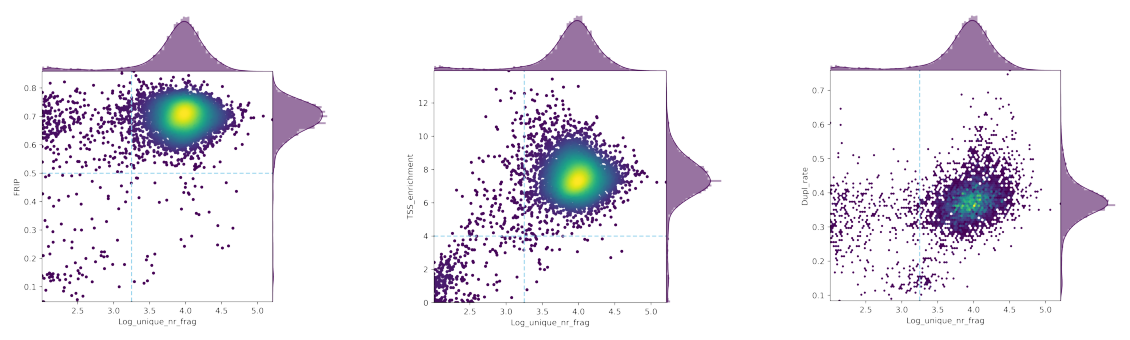

In [31]:
runID = 'MMlines_7'
print(f"filter for sample: {runID}")
fig=plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_figDict[runID]) #To convert figures to plot together, see .utils.py
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_figDict[runID])
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_figDict[runID])
plt.imshow(img)
plt.axis('off')
plt.show()

filter for sample: MMlines_4


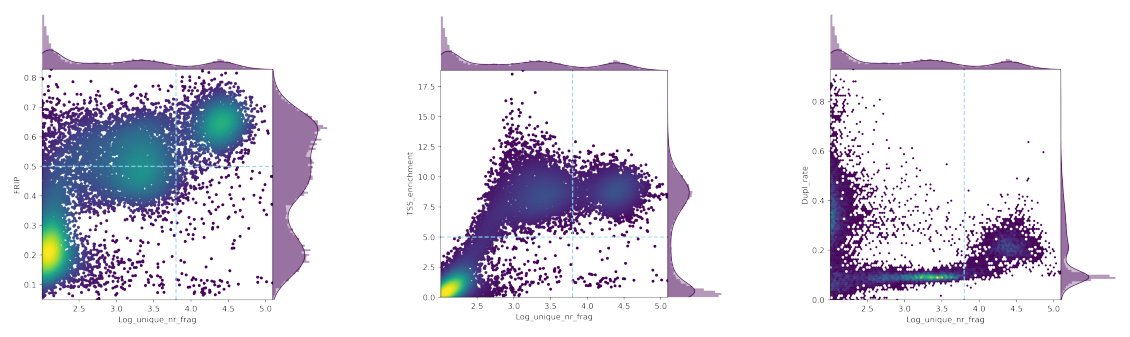

In [32]:
runID = 'MMlines_4'
print(f"filter for sample: {runID}")
fig=plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_figDict[runID]) #To convert figures to plot together, see .utils.py
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_figDict[runID])
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_figDict[runID])
plt.imshow(img)
plt.axis('off')
plt.show()

Select cells passing filters

In [33]:
bc_passing_filters = dict()
for runID in metadata_bc:
    bc_passing_filters[runID] = list((set(FRIP_NR_FRAG_filterDict[runID]) & set(TSS_NR_FRAG_filterDict[runID])))
    print(f"{len(bc_passing_filters[runID])} barcodes passed filters for sample {runID}")

4377 barcodes passed filters for sample MMlines_7
2242 barcodes passed filters for sample MMlines_4


In [34]:
pickle.dump(bc_passing_filters, open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'wb'))

### Creating a cisTopic object and topic modeling

Load data

In [35]:
import pickle
fragments_dict = {
    'MMlines_7': os.path.join(work_dir, 'data/seven_lines_fragments.tsv.gz'),
    'MMlines_4': os.path.join(work_dir, 'data/four_lines_fragments.tsv.gz')}
#note we use twice the same regions!
path_to_regions = {'MMlines_4': os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'),
                  'MMlines_7': os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}
path_to_blacklist= '../../pycisTopic/blacklist/hg38-blacklist.v2.bed'
metadata_bc = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'rb'))
bc_passing_filters = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'rb'))

Next we will create a cisTopic object for each sample, and merge both objects into a single object.

In [37]:
from pycisTopic.cistopic_class import *
cistopic_obj_list=[create_cistopic_object_from_fragments(path_to_fragments=fragments_dict[key],
                                               path_to_regions=path_to_regions[key],
                                               path_to_blacklist=path_to_blacklist,
                                               metrics=metadata_bc[key],
                                               valid_bc=bc_passing_filters[key],
                                               n_cpu=1,
                                               project=key) for key in fragments_dict.keys()]

2022-08-10 11:13:56,108 cisTopic     INFO     Reading data for MMlines_7
2022-08-10 11:14:40,082 cisTopic     INFO     metrics provided!
2022-08-10 11:14:44,785 cisTopic     INFO     valid_bc provided, selecting barcodes!
2022-08-10 11:14:48,902 cisTopic     INFO     Counting fragments in regions
2022-08-10 11:15:12,928 cisTopic     INFO     Creating fragment matrix
2022-08-10 11:16:44,848 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-08-10 11:17:14,012 cisTopic     INFO     Removing blacklisted regions
2022-08-10 11:17:17,679 cisTopic     INFO     Creating CistopicObject
2022-08-10 11:17:19,241 cisTopic     INFO     Done!
2022-08-10 11:17:20,375 cisTopic     INFO     Reading data for MMlines_4
2022-08-10 11:18:30,917 cisTopic     INFO     metrics provided!
2022-08-10 11:18:37,562 cisTopic     INFO     valid_bc provided, selecting barcodes!
2022-08-10 11:18:42,584 cisTopic     INFO     Counting fragments in regions
2022-08-10 11:19:11,374 cisTopic     INFO     

In [38]:
cistopic_obj = merge(cistopic_obj_list)
print(cistopic_obj)

2022-08-10 11:20:31,733 cisTopic     INFO     cisTopic object 1 merged
CistopicObject from project cisTopic_merge with n_cells × n_regions = 6619 × 360117


Add cell metadata

In [42]:
import pandas as pd
cell_data = pd.read_csv(os.path.join(work_dir, 'scATAC/cell_data.tsv'), sep = '\t')
#cistopic makes use of the sample_id to match the correct cell barcodes to the metadata, let's add the sample_id as a suffix to the cell barcodes
cell_data['barcode'] = cell_data['barcode'] +'___'+ cell_data['sample_id']
print(cell_data['barcode'][0:5])
cell_data = cell_data.set_index('barcode')
cistopic_obj.add_cell_data(cell_data[['MMline']])

0    AAACGAAAGAGAGGTA-1___MMlines_7
1    AAACGAAAGCGTATCT-1___MMlines_7
2    AAACGAAGTGCAAGCA-1___MMlines_7
3    AAACGAAGTGCAGACA-1___MMlines_7
4    AAACGAATCGATAGGG-1___MMlines_7
Name: barcode, dtype: object



Detect and remove doublets using Scrublet

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.73
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 7.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.5%
Elapsed time: 70.4 seconds
Detected doublet rate = 8.2%
Estimated detectable doublet fraction = 52.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 15.4%


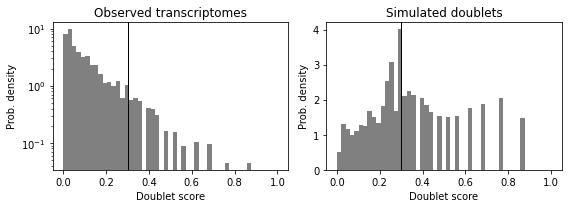

In [71]:
import scrublet as scr
scrub = scr.Scrublet(cistopic_obj.fragment_matrix.T, expected_doublet_rate=0.1)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
scrub.call_doublets(threshold=0.3)
scrub.plot_histogram()
scrublet = pd.DataFrame([scrub.doublet_scores_obs_, scrub.predicted_doublets_], columns=cistopic_obj.cell_names, index=['Doublet_scores_fragments', 'Predicted_doublets_fragments']).T
singlets = cistopic_obj.cell_data[cistopic_obj.cell_data.Predicted_doublets_fragments == False].index.tolist()
cistopic_obj = cistopic_obj.subset(singlets, copy=True)

In [44]:
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

Run topic modeling

In [45]:
import pickle
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.cistopic_class import *
sys.stderr = open(os.devnull, "w")  # silence stderr
models=run_cgs_models(cistopic_obj,
                    n_topics=[2,5,10,15,30,45],
                    n_cpu=6,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None,
                    _temp_dir = os.path.join(tmp_dir + 'ray_spill'))
sys.stderr = sys.__stderr__  # unsilence stderr

(run_cgs_model pid=14077) 2022-08-10 11:35:40,132 cisTopic     INFO     Running model with 45 topics
(run_cgs_model pid=14076) 2022-08-10 11:35:40,132 cisTopic     INFO     Running model with 2 topics
(run_cgs_model pid=14073) 2022-08-10 11:35:40,132 cisTopic     INFO     Running model with 10 topics
(run_cgs_model pid=14075) 2022-08-10 11:35:40,132 cisTopic     INFO     Running model with 5 topics
(run_cgs_model pid=14074) 2022-08-10 11:35:40,132 cisTopic     INFO     Running model with 30 topics
(run_cgs_model pid=14078) 2022-08-10 11:35:40,132 cisTopic     INFO     Running model with 15 topics
(run_cgs_model pid=14076) 2022-08-10 12:00:24,225 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=14075) 2022-08-10 12:18:45,848 cisTopic     INFO     Model with 5 topics done!
(run_cgs_model pid=14073) 2022-08-10 12:54:26,310 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=14078) 2022-08-10 13:28:48,771 cisTopic     INFO     Model with 15 topics done!
(r

In [46]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/models')):
    os.makedirs(os.path.join(work_dir, 'scATAC/models'))

pickle.dump(models,
    open(os.path.join(work_dir, 'scATAC/models/mix_mm_models_500_iter_LDA.pkl'), 'wb'))

Model selection

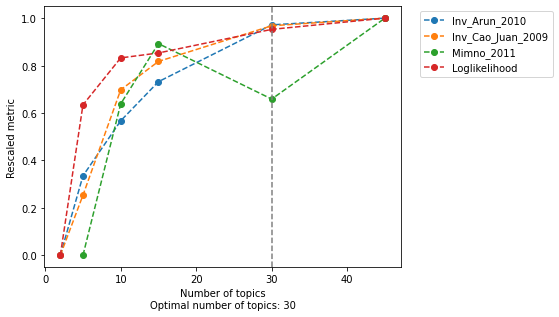

In [49]:
numTopics = 30
model = evaluate_models(models,
                     select_model = numTopics, 
                     return_model = True, 
                     metrics = ['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics = False)

Add model to cistopic object.

In [50]:
cistopic_obj.add_LDA_model(model)

In [51]:
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

### Visualization

In [84]:
from pycisTopic.clust_vis import run_umap
color_dict_line = {
    'MM001': '#9A031E', 
    'MM011': '#C75146', 
    'MM031': '#FFA987',
    'MM074': '#222E50',
    'MM087': '#8BB174',
    'MM057': '#2A4849',
    'MM050': '#626868', 
    'MM029': '#3E5641', 
    'MM047': '#59A96A',  
    'MM099': '#56E39F', 
    'MM116': '#1B3022'
}
run_umap(cistopic_obj, target = 'cell', scale = True)

2022-08-11 09:24:10,735 cisTopic     INFO     Running UMAP


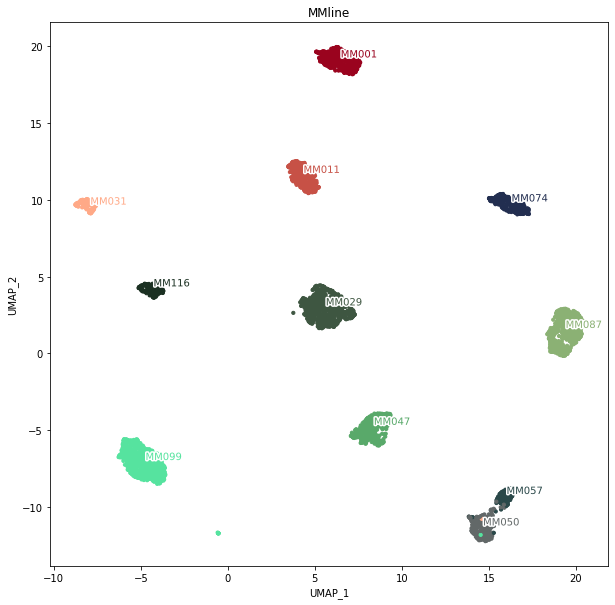

In [85]:
from pycisTopic.clust_vis import plot_metadata
plot_metadata(
    cistopic_obj,
    reduction_name = 'UMAP',
    color_dictionary = {'MMline': color_dict_line},
    variables = ['MMline'],
    figsize = (10, 10))

Each line belongs to one of three states, the melanocytic state (mel), the intermediate state (int) or the mesenchymal state (mes).let's add this annotation.



In [95]:
line_to_state = {
    'MM001': 'MEL', 
    'MM011': 'MEL', 
    'MM031': 'MEL',
    'MM074': 'INT',
    'MM087': 'INT',
    'MM057': 'INT',
    'MM050': 'INT', 
    'MM029': 'MES', 
    'MM047': 'MES',  
    'MM099': 'MES', 
    'MM116': 'MES'
}
cistopic_obj.cell_data['line_type'] = [line_to_state[line] if str(line) != 'nan' else np.nan for line in cistopic_obj.cell_data['MMline']]

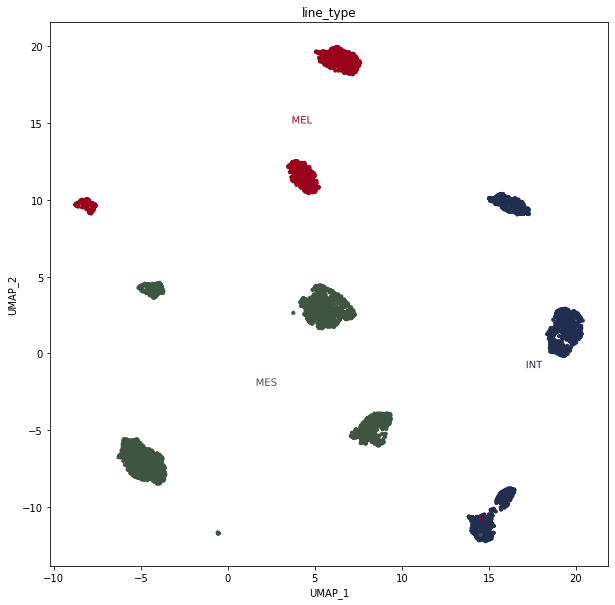

In [96]:
color_dict_state = {
    'MEL': '#9A031E', 
    'INT': '#222E50', 
    'MES': '#3E5641',
}
from pycisTopic.clust_vis import plot_metadata
plot_metadata(
    cistopic_obj,
    reduction_name = 'UMAP',
    color_dictionary = {'line_type': color_dict_state},
    variables = ['line_type'],
    figsize = (10, 10))

### Inferring candidate enhancer regions

Next we will infer candidate enhancer regions by binarization of region-topic probabilities ad calculating differentially accessible regions.

These regions will be used for the next step, pycistarget, in which we will look wich motifs are enriched in these regions.

This approach is the same as we would do with multiome data.

In the interest of time, will only use the otsu method in this case for topic binarization.

In [97]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')

<Figure size 460.8x345.6 with 0 Axes>

Calculate differential accessible regions (DARs).

We will calculate DARs for each line (i.e. each line vs all other lines), for each state (i.e. each state vs all other states) and for the specific contrast of melanocytic (MEL) and intermediate (INT) states versus the mesenchymal state (MES).

In [98]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)

2022-08-11 09:46:38,131 cisTopic     INFO     Imputing drop-outs
2022-08-11 09:46:59,568 cisTopic     INFO     Scaling
2022-08-11 09:47:08,113 cisTopic     INFO     Keep non zero rows
2022-08-11 09:47:26,046 cisTopic     INFO     Imputed accessibility sparsity: 0.5490465157248885
2022-08-11 09:47:26,048 cisTopic     INFO     Create CistopicImputedFeatures object
2022-08-11 09:47:26,049 cisTopic     INFO     Done!
2022-08-11 09:47:26,050 cisTopic     INFO     Normalizing imputed data
2022-08-11 09:48:17,742 cisTopic     INFO     Done!
2022-08-11 09:48:17,747 cisTopic     INFO     Calculating mean
2022-08-11 09:48:20,728 cisTopic     INFO     Calculating variance
2022-08-11 09:48:50,786 cisTopic     INFO     Done!


<Figure size 432x288 with 0 Axes>

In [127]:
print('Calculating DARs for each MM line...')
markers_dict_MMline = find_diff_features(cistopic_obj, imputed_acc_obj, variable='MMline', var_features=variable_regions, split_pattern = '-')
print('Calculating DARs for each state...')
markers_dict_state = find_diff_features(cistopic_obj, imputed_acc_obj, variable='line_type', var_features=variable_regions, split_pattern = '-')
print('Calculating DARs for the contract MEL + INT vs MES')
contrasts = [[['MEL','INT'], ['MES']], [['MES'], ['MEL','INT']]]
markers_dict_MEL_INT_v_MES = find_diff_features(cistopic_obj, imputed_acc_obj, variable='line_type', var_features=variable_regions, split_pattern = '-', contrasts = contrasts)

Calculating DARs for each MM line...
Calculating DARs for each state...
Calculating DARs for the contract MEL + INT vs MES
2022-08-11 11:04:00,480 cisTopic     INFO     Formatting data for MEL_INT_VS_MES
2022-08-11 11:04:06,713 cisTopic     INFO     Computing p-value for MEL_INT_VS_MES
2022-08-11 11:05:22,961 cisTopic     INFO     Computing log2FC for MEL_INT_VS_MES
2022-08-11 11:05:25,892 cisTopic     INFO     MEL_INT_VS_MES done!
2022-08-11 11:05:25,968 cisTopic     INFO     Formatting data for MES_VS_MEL_INT
2022-08-11 11:05:33,114 cisTopic     INFO     Computing p-value for MES_VS_MEL_INT
2022-08-11 11:06:49,165 cisTopic     INFO     Computing log2FC for MES_VS_MEL_INT
2022-08-11 11:06:51,976 cisTopic     INFO     MES_VS_MEL_INT done!


In [128]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/candidate_enhancers')):
    os.makedirs(os.path.join(work_dir, 'scATAC/candidate_enhancers'))
import pickle
pickle.dump(region_bin_topics_otsu, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(markers_dict_MMline, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict_MMline.pkl'), 'wb'))
pickle.dump(markers_dict_state, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict_state.pkl'), 'wb'))
pickle.dump(markers_dict_MEL_INT_v_MES, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict_MEL_INT_v_MES.pkl'), 'wb'))

## Motif enrichment analysis using pycistarget

Load candidate enhancer regions identified in previous step.

In [2]:
import pickle
region_bin_topics_otsu = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'rb'))
markers_dict_MMline = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict_MMline.pkl'), 'rb'))
markers_dict_state = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict_state.pkl'), 'rb'))
markers_dict_MEL_INT_v_MES = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict_MEL_INT_v_MES.pkl'), 'rb'))

Convert to dictionary of pyranges objects.

In [3]:
import pyranges as pr
from pycistarget.utils import region_names_to_coordinates
region_sets = {}
region_sets['topics_otsu'] = {}
region_sets['DARs_MMline'] = {}
region_sets['DARs_state'] = {}
region_sets['DARs_MEL_INT_v_MES'] = {}
for topic in region_bin_topics_otsu.keys():
    regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_otsu'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for DAR in markers_dict_MMline.keys():
    regions = markers_dict_MMline[DAR].index[markers_dict_MMline[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['DARs_MMline'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))
for DAR in markers_dict_state.keys():
    regions = markers_dict_state[DAR].index[markers_dict_state[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['DARs_state'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))
for DAR in markers_dict_MEL_INT_v_MES.keys():
    regions = markers_dict_MEL_INT_v_MES[DAR].index[markers_dict_MEL_INT_v_MES[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['DARs_MEL_INT_v_MES'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))
for key in region_sets.keys():
    print(f'{key}: {region_sets[key].keys()}')

topics_otsu: dict_keys(['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16', 'Topic17', 'Topic18', 'Topic19', 'Topic20', 'Topic21', 'Topic22', 'Topic23', 'Topic24', 'Topic25', 'Topic26', 'Topic27', 'Topic28', 'Topic29', 'Topic30'])
DARs_MMline: dict_keys(['MM001', 'MM011', 'MM029', 'MM031', 'MM047', 'MM050', 'MM057', 'MM074', 'MM087', 'MM099', 'MM116'])
DARs_state: dict_keys(['INT', 'MEL', 'MES'])
DARs_MEL_INT_v_MES: dict_keys(['MEL_INT_VS_MES', 'MES_VS_MEL_INT'])


For this analysis we will make use a custom made cistarget database on the consensus peaks.

In [4]:
db_fpath = "/staging/leuven/stg_00002/lcb/saibar/Projects/PanCancer/1_runs_separateCancers/MMlines_1_sc/pycistopic_dbs_run1"
motif_annot_fpath = "/staging/leuven/stg_00002/lcb/cbravo/cluster_motif_collection_V10_no_desso_no_factorbook/snapshots"

In [5]:
rankings_db = os.path.join(db_fpath, 'mel_9sc.regions_vs_motifs.rankings.fv2.feather')
scores_db =  os.path.join(db_fpath, 'mel_9sc.regions_vs_motifs.scores.fv2.feather')
motif_annotation = os.path.join(motif_annot_fpath, 'motifs-v10-nr.hgnc-m0.00001-o0.0.tbl')

In [6]:
if not os.path.exists(os.path.join(work_dir, 'motifs')):
    os.makedirs(os.path.join(work_dir, 'motifs'))

In [7]:
from scenicplus.wrappers.run_pycistarget import run_pycistarget
sys.stderr = open(os.devnull, "w")  # silence stderr
run_pycistarget(
    region_sets = region_sets,
    species = 'homo_sapiens',
    save_path = os.path.join(work_dir, 'motifs'),
    ctx_db_path = rankings_db,
    dem_db_path = scores_db,
    path_to_motif_annotations = motif_annotation,
    run_without_promoters = True,
    n_cpu = 10,
    _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
    annotation_version = 'v10nr_clust')
sys.stderr = sys.__stderr__  # unsilence stderr

2022-08-11 14:27:04,056 pycisTarget_wrapper INFO     mm_lines/motifs folder already exists.
2022-08-11 14:27:04,714 pycisTarget_wrapper INFO     Loading cisTarget database for topics_otsu
2022-08-11 14:27:04,715 cisTarget    INFO     Reading cisTarget database
2022-08-11 14:28:01,253 pycisTarget_wrapper INFO     Running cisTarget for topics_otsu
2022-08-11 14:28:53,716 cisTarget    INFO     Done!
2022-08-11 14:28:53,718 pycisTarget_wrapper INFO     mm_lines/motifs/CTX_topics_otsu_All folder already exists.
2022-08-11 14:28:54,175 pycisTarget_wrapper INFO     Running cisTarget without promoters for topics_otsu
2022-08-11 14:30:01,217 cisTarget    INFO     Done!
2022-08-11 14:30:01,218 pycisTarget_wrapper INFO     mm_lines/motifs/CTX_topics_otsu_No_promoters folder already exists.
2022-08-11 14:30:01,604 pycisTarget_wrapper INFO     Running DEM for topics_otsu
2022-08-11 14:30:01,605 DEM          INFO     Reading DEM database
2022-08-11 14:30:54,238 DEM          INFO     Creating contras

## inferring enhancer-driven Gene Regulatory Networks (eGRNs) using SCENIC+

We now have completed all the steps for running the SCENIC+ analysis.

We will start by creating a scenicplus object containing all the analysis we have done up to this point.

For this we will need to load:

1. the AnnData object containing the scRNA-seq side of the analysis.
2. the cisTopic object containing the scATAC-seq side of the analysis.
3. the motif enrichment dictionary containing the motif enrichment results.

In [15]:
import dill
import scanpy as sc
import os
import warnings
warnings.filterwarnings("ignore")
import pandas
import pyranges
# Set stderr to null to avoid strange messages from ray
import sys
_stderr = sys.stderr
null = open(os.devnull,'wb')
work_dir = 'mm_lines'
tmp_dir = '/scratch/leuven/330/vsc33053/'

adata = sc.read_h5ad(os.path.join(work_dir, 'data/mm_line_anndata.h5ad'))
cistopic_obj = dill.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
menr = dill.load(open(os.path.join(work_dir, 'motifs/menr.pkl'), 'rb'))

Before we are able to run SCENIC+ we have to combine the scATAC-seq and the scRNA-seq data into a *pseudo* multiome dataset.

The way we do this is by randomly sampling a number of cells from the scATAC-seq and scRNA-seq data for each cell type annotation (in this case this is each cell line).
We then average the scRNA-seq and scATAc-seq counts within these cells (of the same cell line) to generate metacells containing both scATAC-seq and scRNA-seq data.

We have implemented this functionality in the `create_SCENICPLUS_object` function, by setting `multi_ome_mode` to `False` we tell the function that we are working with seperate scATAC-seq and scRNA-seq data.
The function will then generate the metacells and consequently a pseudo-multiome dataset based on the annotation provided by the `key_to_group_by` parameter.

We can also specify the amount of cells from which to sample to generate the metacells by setting the `nr_cells_per_metacells` parameter.

In this example it will, for each cell line, sample 5 cells from both the scRNA-seq and scATAC-seq data and average the signals to generate a single metacell.
For each annotation the amount of metacells that are generated is determined automatically so that each cell is sampled at maximum twice. 

In [16]:
from scenicplus.scenicplus_class import create_SCENICPLUS_object
import numpy as np
scplus_obj = create_SCENICPLUS_object(
        GEX_anndata = adata,
        cisTopic_obj = cistopic_obj,
        menr = menr,
        multi_ome_mode = False,
        key_to_group_by = 'MMline',
        nr_cells_per_metacells = 5)

2022-08-11 15:04:26,537 cisTopic     INFO     Imputing drop-outs
2022-08-11 15:04:32,192 cisTopic     INFO     Scaling
2022-08-11 15:04:36,937 cisTopic     INFO     Keep non zero rows
2022-08-11 15:04:45,820 cisTopic     INFO     Imputed accessibility sparsity: 0.5490465157248885
2022-08-11 15:04:45,821 cisTopic     INFO     Create CistopicImputedFeatures object
2022-08-11 15:04:45,822 cisTopic     INFO     Done!
2022-08-11 15:04:45,830 create scenicplus object INFO     Following annotations were found in both assays under key MMline:
	MM029, MM011, MM001, MM057, MM099, MM087, MM031, MM074, MM047.
Keeping 2685 cells for RNA and 4602 for ATAC.
2022-08-11 15:05:13,306 create scenicplus object INFO     Automatically set `nr_metacells` to: MM001: 148, MM011: 106, MM029: 44, MM031: 64, MM047: 100, MM057: 94, MM074: 152, MM087: 112, MM099: 116
2022-08-11 15:05:13,308 create scenicplus object INFO     Generating pseudo multi-ome data


You might have noticed that some cell lines are missing in the scplus_obj (if you compare with the UMAP plot above).

The reason for this is that for some cell lines we only have scATAC-seq data but no scRNA-seq data and vice versa

Only the cell lines which have both will be included in the object.

In [18]:
print(f"The cell lines for which we have scRNA-seq data are:\t{', '.join(set(adata.obs['MMline']) - set(['-']))}")
print(f"The cell lines for which we have scATAC-seq data are:\t{', '.join(set(cistopic_obj.cell_data['MMline']))}")
print(f"The cell lines for which we have both:\t{', '.join(set(cistopic_obj.cell_data['MMline']) & set(adata.obs['MMline']))}")

The cell lines for which we have scRNA-seq data are:	MM029, MM011, MM001, MM057, MM099, MM087, A375, MM031, MM074, MM047
The cell lines for which we have scATAC-seq data are:	MM029, MM011, MM001, MM057, MM099, MM087, MM031, MM074, MM047
The cell lines for which we have both:	MM029, MM011, MM001, MM057, MM099, MM087, MM031, MM074, MM047


Now we can run SCENIC+ as usual.

First let's check with which biomart host our gene names match.

In [19]:
ensembl_version_dict = {'105': 'http://www.ensembl.org',
                        '104': 'http://may2021.archive.ensembl.org/',
                        '103': 'http://feb2021.archive.ensembl.org/',
                        '102': 'http://nov2020.archive.ensembl.org/',
                        '101': 'http://aug2020.archive.ensembl.org/',
                        '100': 'http://apr2020.archive.ensembl.org/',
                        '99': 'http://jan2020.archive.ensembl.org/',
                        '98': 'http://sep2019.archive.ensembl.org/',
                        '97': 'http://jul2019.archive.ensembl.org/',
                        '96': 'http://apr2019.archive.ensembl.org/',
                        '95': 'http://jan2019.archive.ensembl.org/',
                        '94': 'http://oct2018.archive.ensembl.org/',
                        '93': 'http://jul2018.archive.ensembl.org/',
                        '92': 'http://apr2018.archive.ensembl.org/',
                        '91': 'http://dec2017.archive.ensembl.org/',
                        '90': 'http://aug2017.archive.ensembl.org/',
                        '89': 'http://may2017.archive.ensembl.org/',
                        '88': 'http://mar2017.archive.ensembl.org/',
                        '87': 'http://dec2016.archive.ensembl.org/',
                        '86': 'http://oct2016.archive.ensembl.org/',
                        '80': 'http://may2015.archive.ensembl.org/',
                        '77': 'http://oct2014.archive.ensembl.org/',
                        '75': 'http://feb2014.archive.ensembl.org/',
                        '54': 'http://may2009.archive.ensembl.org/'}

import pybiomart as pbm
def test_ensembl_host(scplus_obj, host, species):
    dataset = pbm.Dataset(name=species+'_gene_ensembl',  host=host)
    annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
    annot.columns = ['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    annot['Chromosome'] = annot['Chromosome'].astype('str')
    filter = annot['Chromosome'].str.contains('CHR|GL|JH|MT')
    annot = annot[~filter]
    annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    gene_names_release = set(annot['Gene'].tolist())
    ov=len([x for x in scplus_obj.gene_names if x in gene_names_release])
    print('Genes recovered: ' + str(ov) + ' out of ' + str(len(scplus_obj.gene_names)))
    return ov

n_overlap = {}
for version in ensembl_version_dict.keys():
    print(f'host: {version}')
    try:
        n_overlap[version] =  test_ensembl_host(scplus_obj, ensembl_version_dict[version], 'hsapiens')
    except:
        print('Host not reachable')
v = sorted(n_overlap.items(), key=lambda item: item[1], reverse=True)[0][0]
print(f"version: {v} has the largest overlap, use {ensembl_version_dict[v]} as biomart host")

host: 105
Genes recovered: 14925 out of 18878
host: 104
Genes recovered: 15037 out of 18878
host: 103
Genes recovered: 15185 out of 18878
host: 102
Genes recovered: 15196 out of 18878
host: 101
Genes recovered: 15216 out of 18878
host: 100
Genes recovered: 15224 out of 18878
host: 99
Genes recovered: 15239 out of 18878
host: 98
Genes recovered: 15361 out of 18878
host: 97
Genes recovered: 15361 out of 18878
host: 96
Genes recovered: 15402 out of 18878
host: 95
Genes recovered: 15480 out of 18878
host: 94
Genes recovered: 15497 out of 18878
host: 93
Genes recovered: 15495 out of 18878
host: 92
Genes recovered: 15582 out of 18878
host: 91
Genes recovered: 15680 out of 18878
host: 90
Genes recovered: 15714 out of 18878
host: 89
Genes recovered: 15751 out of 18878
host: 88
Genes recovered: 18479 out of 18878
host: 87
Host not reachable
host: 86
Host not reachable
host: 80
Genes recovered: 18660 out of 18878
host: 77
Genes recovered: 18410 out of 18878
host: 75
Host not reachable
host: 54
H

In [24]:
biomart_host = "http://may2015.archive.ensembl.org"

And let's run the SCENIC+ workflow

In [21]:
!wget -O mm_lines/data/utoronto_human_tfs_v_1.01.txt  http://humantfs.ccbr.utoronto.ca/download/v_1.01/TF_names_v_1.01.txt

--2022-08-11 15:07:46--  http://humantfs.ccbr.utoronto.ca/download/v_1.01/TF_names_v_1.01.txt
Resolving humantfs.ccbr.utoronto.ca (humantfs.ccbr.utoronto.ca)... 142.150.52.218
Connecting to humantfs.ccbr.utoronto.ca (humantfs.ccbr.utoronto.ca)|142.150.52.218|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11838 (12K) [text/plain]
Saving to: ‘mm_lines/data/utoronto_human_tfs_v_1.01.txt’

100%[======================================>] 11,838      --.-K/s   in 0.1s    

2022-08-11 15:07:47 (113 KB/s) - ‘mm_lines/data/utoronto_human_tfs_v_1.01.txt’ saved [11838/11838]



<div class="alert alert-info">

**Note:**

For this example we will run the bare minimum sceniplus workflow (without exporting to loom, UCSC, ...).

</div>


In [25]:
from scenicplus.wrappers.run_scenicplus import run_scenicplus
try:
    sys.stderr = open(os.devnull, "w")  # silence stderr
    run_scenicplus(
        scplus_obj = scplus_obj,
        variable = ['MMline'],
        species = 'hsapiens',
        assembly = 'hg38',
        tf_file = 'mm_lines/data/utoronto_human_tfs_v_1.01.txt',
        save_path = os.path.join(work_dir, 'scenicplus'),
        biomart_host = biomart_host,
        upstream = [1000, 150000],
        downstream = [1000, 150000],
        calculate_TF_eGRN_correlation = False,
        calculate_DEGs_DARs = False,
        export_to_loom_file = False,
        export_to_UCSC_file = False,
        n_cpu = 12,
        _temp_dir = os.path.join(tmp_dir, 'ray_spill'))  
    sys.stderr = sys.__stderr__  # unsilence stderr
except Exception as e:
    #in case of failure, still save the object
    dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)
    raise(e)

2022-08-11 15:26:34,432 SCENIC+_wrapper INFO     mm_lines/scenicplus folder already exists.
2022-08-11 15:26:34,433 SCENIC+_wrapper INFO     Getting search space
2022-08-11 15:26:35,677 R2G          INFO     Downloading gene annotation from biomart dataset: hsapiens_gene_ensembl
2022-08-11 15:26:52,699 R2G          INFO     Downloading chromosome sizes from: http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes
2022-08-11 15:26:53,624 R2G          INFO     Extending promoter annotation to 10 bp upstream and 10 downstream
2022-08-11 15:26:55,320 R2G          INFO     Extending search space to:
            						150000 bp downstream of the end of the gene.
            						150000 bp upstream of the start of the gene.
2022-08-11 15:27:08,237 R2G          INFO     Intersecting with regions.
2022-08-11 15:27:09,308 R2G          INFO     Calculating distances from region to gene
2022-08-11 15:29:23,674 R2G          INFO     Imploding multiple entries per region and gene
20

## Downstream analysis

In [4]:
import dill
scplus_obj = dill.load(open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'rb'))

### Simplifying and filtering SCENIC+ output

In [5]:
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)
scplus_obj.uns['eRegulon_metadata_filtered'].head()

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
0,ARID3A_+_(214r),ARID3A_+_(130g),ARID3A,False,chr2:27264943-27265443,ZNF513,0.040601,0.136648,0.005548,0.005548,5.891225,1,0.068561,0.403906,0.403906,ARID3A_+_+
1,ARID3A_+_(214r),ARID3A_+_(130g),ARID3A,False,chr2:27430444-27430944,ZNF513,0.026327,0.191896,0.005052,0.005052,5.891225,1,0.068561,0.403906,0.403906,ARID3A_+_+
2,ARID3A_+_(214r),ARID3A_+_(130g),ARID3A,False,chr6:31772820-31773320,HSPA1B,0.018390,0.065314,0.001201,0.001201,0.561581,1,0.120816,0.067848,0.067848,ARID3A_+_+
3,ARID3A_+_(214r),ARID3A_+_(130g),ARID3A,False,chr6:31952273-31952773,HSPA1B,0.043124,0.232441,0.010024,0.010024,0.561581,1,0.120816,0.067848,0.067848,ARID3A_+_+
4,ARID3A_+_(214r),ARID3A_+_(130g),ARID3A,False,chr3:194575822-194576322,TMEM44,0.055162,0.230298,0.012704,0.012704,0.545907,1,0.068665,0.037485,0.037485,ARID3A_+_+


Score filtered eRegulons

In [8]:
from scenicplus.eregulon_enrichment import score_eRegulons
region_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/region_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
gene_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/gene_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 5)
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.05,
                normalize= False,
                n_cpu = 5)

### Get high quality eRegulons based on TF expression-to-AUC value correlation.

In [10]:
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks

generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'MMline',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Gene_based')
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'MMline',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Region_based')

TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'MMline',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'MMline',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

/user/leuven/330/vsc33053/sdewin/Programs/anaconda3/envs/scenicplus/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/user/leuven/330/vsc33053/sdewin/Programs/anaconda3/envs/scenicplus/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/user/leuven/330/vsc33053/sdewin/Programs/anaconda3/envs/scenicplus/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


/local_scratch/tmp-vsc33053/ipykernel_6338/3964952566.py:13: RuntimeWarning: divide by zero encountered in log10
  sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)


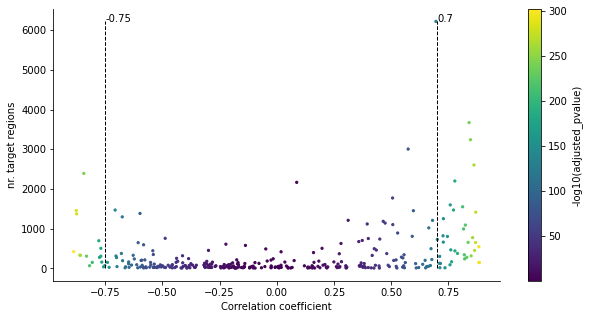

In [12]:
import numpy as np
n_targets = [int(x.split('(')[1].replace('r)', '')) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Adjusted_p-value'].to_list()

thresholds = {
        'rho': [-0.75, 0.70],
        'n_targets': 0
}
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('nr. target regions')
#ax.hlines(y = thresholds['n_targets'], xmin = min(rho), xmax = max(rho), color = 'black', ls = 'dashed', lw = 1)
ax.vlines(x = thresholds['rho'], ymin = 0, ymax = max(n_targets), color = 'black', ls = 'dashed', lw = 1)
ax.text(x = thresholds['rho'][0], y = max(n_targets), s = str(thresholds['rho'][0]))
ax.text(x = thresholds['rho'][1], y = max(n_targets), s = str(thresholds['rho'][1]))
sns.despine(ax = ax)
fig.colorbar(sc, label = '-log10(adjusted_pvalue)', ax = ax)
plt.show()

In [13]:
selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 56 eRegulons


### Plot dotplot

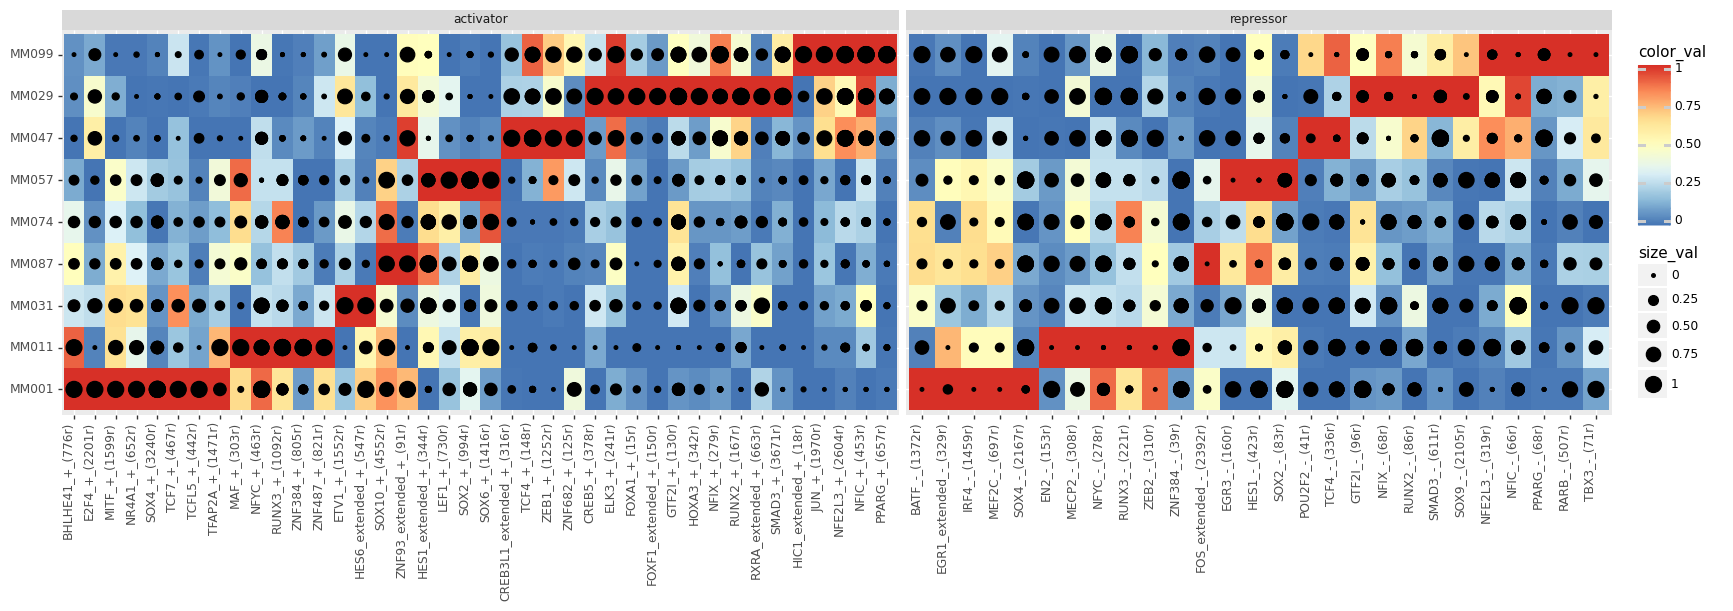

<ggplot: (2933104367086)>

In [17]:
from scenicplus.plotting.dotplot import heatmap_dotplot
heatmap_dotplot(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'], #specify what to plot as dot sizes, target region enrichment in this case
        color_matrix = scplus_obj.to_df('EXP'), #specify  what to plot as colors, TF expression in this case
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'MMline',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
        index_order = ['MM001', 'MM011', 'MM031', 'MM087', 'MM074', 'MM057', 'MM047', 'MM029', 'MM099'],
        figsize = (20, 5),
        orientation = 'horizontal')

In [18]:
dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)